# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.GELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.GELU(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 20, 20, 20, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=20, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 20, 20, 20, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.0498
Epoch 1/200, Iteration 2/12, Loss: 1.1244
Epoch 1/200, Iteration 3/12, Loss: 0.9147
Epoch 1/200, Iteration 4/12, Loss: 1.0322
Epoch 1/200, Iteration 5/12, Loss: 0.9631
Epoch 1/200, Iteration 6/12, Loss: 0.8125
Epoch 1/200, Iteration 7/12, Loss: 1.0059
Epoch 1/200, Iteration 8/12, Loss: 1.0013
Epoch 1/200, Iteration 9/12, Loss: 0.8698
Epoch 1/200, Iteration 10/12, Loss: 0.7506
Epoch 1/200, Iteration 11/12, Loss: 0.7326
Epoch 1/200, Iteration 12/12, Loss: 0.6123
Epoch 1/200, Iteration 13/12, Loss: 0.5085
Train Error: 
 Accuracy: 39.25%, Avg loss: 0.466680, MRE: 0.453574, MAE: 0.072094 

Test Error: 
 Accuracy: 38.0%, Avg loss: 0.468024, MRE: 0.395001, MAE: 0.070227 

Epoch 2/200, Iteration 1/12, Loss: 0.4119
Epoch 2/200, Iteration 2/12, Loss: 0.5371
Epoch 2/200, Iteration 3/12, Loss: 0.3707
Epoch 2/200, Iteration 4/12, Loss: 0.3073
Epoch 2/200, Iteration 5/12, Loss: 0.2379
Epoch 2/200, Iteration 6/12, Loss: 0.1876
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.002517, MRE: 0.025942, MAE: 0.004497 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.002564, MRE: 0.022543, MAE: 0.004997 

Epoch 13/200, Iteration 1/12, Loss: 0.0034
Epoch 13/200, Iteration 2/12, Loss: 0.0029
Epoch 13/200, Iteration 3/12, Loss: 0.0024
Epoch 13/200, Iteration 4/12, Loss: 0.0019
Epoch 13/200, Iteration 5/12, Loss: 0.0027
Epoch 13/200, Iteration 6/12, Loss: 0.0025
Epoch 13/200, Iteration 7/12, Loss: 0.0049
Epoch 13/200, Iteration 8/12, Loss: 0.0019
Epoch 13/200, Iteration 9/12, Loss: 0.0034
Epoch 13/200, Iteration 10/12, Loss: 0.0016
Epoch 13/200, Iteration 11/12, Loss: 0.0026
Epoch 13/200, Iteration 12/12, Loss: 0.0052
Epoch 13/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.002921, MRE: 0.029521, MAE: 0.005044 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.002392, MRE: 0.023766, MAE: 0.004929 

Epoch 14/200, Iteration 1/12, Loss: 0.0041
Epoch 14/200, Iteration 2/12, Loss: 0.0038
Epoch 14/200, Itera

Epoch 25/200, Iteration 3/12, Loss: 0.0009
Epoch 25/200, Iteration 4/12, Loss: 0.0008
Epoch 25/200, Iteration 5/12, Loss: 0.0007
Epoch 25/200, Iteration 6/12, Loss: 0.0012
Epoch 25/200, Iteration 7/12, Loss: 0.0007
Epoch 25/200, Iteration 8/12, Loss: 0.0005
Epoch 25/200, Iteration 9/12, Loss: 0.0014
Epoch 25/200, Iteration 10/12, Loss: 0.0011
Epoch 25/200, Iteration 11/12, Loss: 0.0012
Epoch 25/200, Iteration 12/12, Loss: 0.0014
Epoch 25/200, Iteration 13/12, Loss: 0.0007
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.001342, MRE: 0.017514, MAE: 0.003251 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001227, MRE: 0.017291, MAE: 0.003419 

Epoch 26/200, Iteration 1/12, Loss: 0.0012
Epoch 26/200, Iteration 2/12, Loss: 0.0008
Epoch 26/200, Iteration 3/12, Loss: 0.0006
Epoch 26/200, Iteration 4/12, Loss: 0.0006
Epoch 26/200, Iteration 5/12, Loss: 0.0009
Epoch 26/200, Iteration 6/12, Loss: 0.0010
Epoch 26/200, Iteration 7/12, Loss: 0.0010
Epoch 26/200, Iteration 8/12, Loss: 0.0015
Epoch 26/200, 

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000907, MRE: 0.014188, MAE: 0.002714 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000868, MRE: 0.012395, MAE: 0.002675 

Epoch 37/200, Iteration 1/12, Loss: 0.0007
Epoch 37/200, Iteration 2/12, Loss: 0.0014
Epoch 37/200, Iteration 3/12, Loss: 0.0008
Epoch 37/200, Iteration 4/12, Loss: 0.0010
Epoch 37/200, Iteration 5/12, Loss: 0.0008
Epoch 37/200, Iteration 6/12, Loss: 0.0012
Epoch 37/200, Iteration 7/12, Loss: 0.0012
Epoch 37/200, Iteration 8/12, Loss: 0.0006
Epoch 37/200, Iteration 9/12, Loss: 0.0010
Epoch 37/200, Iteration 10/12, Loss: 0.0013
Epoch 37/200, Iteration 11/12, Loss: 0.0009
Epoch 37/200, Iteration 12/12, Loss: 0.0010
Epoch 37/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000694, MRE: 0.014233, MAE: 0.002189 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000527, MRE: 0.010532, MAE: 0.002167 

Epoch 38/200, Iteration 1/12, Loss: 0.0005
Epoch 38/200, Iteration 2/12, Loss: 0.0007
Epoch 38/200, Iterat

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000467, MRE: 0.011348, MAE: 0.001995 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000496, MRE: 0.010195, MAE: 0.002074 

Epoch 49/200, Iteration 1/12, Loss: 0.0005
Epoch 49/200, Iteration 2/12, Loss: 0.0003
Epoch 49/200, Iteration 3/12, Loss: 0.0005
Epoch 49/200, Iteration 4/12, Loss: 0.0003
Epoch 49/200, Iteration 5/12, Loss: 0.0006
Epoch 49/200, Iteration 6/12, Loss: 0.0004
Epoch 49/200, Iteration 7/12, Loss: 0.0004
Epoch 49/200, Iteration 8/12, Loss: 0.0006
Epoch 49/200, Iteration 9/12, Loss: 0.0004
Epoch 49/200, Iteration 10/12, Loss: 0.0004
Epoch 49/200, Iteration 11/12, Loss: 0.0006
Epoch 49/200, Iteration 12/12, Loss: 0.0006
Epoch 49/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.000533, MRE: 0.013614, MAE: 0.002379 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000502, MRE: 0.012928, MAE: 0.002408 

Epoch 50/200, Iteration 1/12, Loss: 0.0004
Epoch 50/200, Iteration 2/12, Loss: 0.0003
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.001632, MRE: 0.020597, MAE: 0.003949 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001280, MRE: 0.015232, MAE: 0.003784 

Epoch 61/200, Iteration 1/12, Loss: 0.0021
Epoch 61/200, Iteration 2/12, Loss: 0.0020
Epoch 61/200, Iteration 3/12, Loss: 0.0008
Epoch 61/200, Iteration 4/12, Loss: 0.0020
Epoch 61/200, Iteration 5/12, Loss: 0.0014
Epoch 61/200, Iteration 6/12, Loss: 0.0012
Epoch 61/200, Iteration 7/12, Loss: 0.0030
Epoch 61/200, Iteration 8/12, Loss: 0.0011
Epoch 61/200, Iteration 9/12, Loss: 0.0016
Epoch 61/200, Iteration 10/12, Loss: 0.0008
Epoch 61/200, Iteration 11/12, Loss: 0.0012
Epoch 61/200, Iteration 12/12, Loss: 0.0006
Epoch 61/200, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.001292, MRE: 0.017368, MAE: 0.003622 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001256, MRE: 0.016781, MAE: 0.003698 

Epoch 62/200, Iteration 1/12, Loss: 0.0016
Epoch 62/200, Iteration 2/12, Loss: 0.0005
Epoch 62/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000154, MRE: 0.008196, MAE: 0.001140 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000164, MRE: 0.006559, MAE: 0.001222 

Epoch 73/200, Iteration 1/12, Loss: 0.0002
Epoch 73/200, Iteration 2/12, Loss: 0.0002
Epoch 73/200, Iteration 3/12, Loss: 0.0001
Epoch 73/200, Iteration 4/12, Loss: 0.0002
Epoch 73/200, Iteration 5/12, Loss: 0.0003
Epoch 73/200, Iteration 6/12, Loss: 0.0002
Epoch 73/200, Iteration 7/12, Loss: 0.0001
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0001
Epoch 73/200, Iteration 10/12, Loss: 0.0001
Epoch 73/200, Iteration 11/12, Loss: 0.0002
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000154, MRE: 0.008244, MAE: 0.001149 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000162, MRE: 0.006568, MAE: 0.001191 

Epoch 74/200, Iteration 1/12, Loss: 0.0002
Epoch 74/200, Iteration 2/12, Loss: 0.0002
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000144, MRE: 0.008006, MAE: 0.001114 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000156, MRE: 0.006366, MAE: 0.001217 

Epoch 85/200, Iteration 1/12, Loss: 0.0002
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0001
Epoch 85/200, Iteration 4/12, Loss: 0.0002
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0002
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0001
Epoch 85/200, Iteration 9/12, Loss: 0.0002
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0001
Epoch 85/200, Iteration 12/12, Loss: 0.0002
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.007992, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000148, MRE: 0.006130, MAE: 0.001147 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000153, MRE: 0.008183, MAE: 0.001134 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.006071, MAE: 0.001209 

Epoch 97/200, Iteration 1/12, Loss: 0.0001
Epoch 97/200, Iteration 2/12, Loss: 0.0002
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0001
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0001
Epoch 97/200, Iteration 8/12, Loss: 0.0002
Epoch 97/200, Iteration 9/12, Loss: 0.0002
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0002
Epoch 97/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.007959, MAE: 0.001101 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000154, MRE: 0.006359, MAE: 0.001171 

Epoch 98/200, Iteration 1/12, Loss: 0.0002
Epoch 98/200, Iteration 2/12, Loss: 0.0001
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000133, MRE: 0.009853, MAE: 0.001082 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000138, MRE: 0.005881, MAE: 0.001119 

Epoch 109/200, Iteration 1/12, Loss: 0.0002
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Epoch 109/200, Iteration 3/12, Loss: 0.0002
Epoch 109/200, Iteration 4/12, Loss: 0.0002
Epoch 109/200, Iteration 5/12, Loss: 0.0001
Epoch 109/200, Iteration 6/12, Loss: 0.0002
Epoch 109/200, Iteration 7/12, Loss: 0.0002
Epoch 109/200, Iteration 8/12, Loss: 0.0001
Epoch 109/200, Iteration 9/12, Loss: 0.0002
Epoch 109/200, Iteration 10/12, Loss: 0.0001
Epoch 109/200, Iteration 11/12, Loss: 0.0001
Epoch 109/200, Iteration 12/12, Loss: 0.0001
Epoch 109/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000171, MRE: 0.007944, MAE: 0.001184 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000152, MRE: 0.006238, MAE: 0.001265 

Epoch 110/200, Iteration 1/12, Loss: 0.0001
Epoch 110/200, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000134, MRE: 0.008276, MAE: 0.001094 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000134, MRE: 0.006022, MAE: 0.001132 

Epoch 121/200, Iteration 1/12, Loss: 0.0001
Epoch 121/200, Iteration 2/12, Loss: 0.0002
Epoch 121/200, Iteration 3/12, Loss: 0.0001
Epoch 121/200, Iteration 4/12, Loss: 0.0002
Epoch 121/200, Iteration 5/12, Loss: 0.0001
Epoch 121/200, Iteration 6/12, Loss: 0.0001
Epoch 121/200, Iteration 7/12, Loss: 0.0001
Epoch 121/200, Iteration 8/12, Loss: 0.0002
Epoch 121/200, Iteration 9/12, Loss: 0.0001
Epoch 121/200, Iteration 10/12, Loss: 0.0001
Epoch 121/200, Iteration 11/12, Loss: 0.0001
Epoch 121/200, Iteration 12/12, Loss: 0.0003
Epoch 121/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.008208, MAE: 0.001169 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000150, MRE: 0.006406, MAE: 0.001177 

Epoch 122/200, Iteration 1/12, Loss: 0.0002
Epoch 122/200, Iteration 2/12, Loss: 0.0001
Ep

Epoch 133/200, Iteration 5/12, Loss: 0.0002
Epoch 133/200, Iteration 6/12, Loss: 0.0002
Epoch 133/200, Iteration 7/12, Loss: 0.0001
Epoch 133/200, Iteration 8/12, Loss: 0.0001
Epoch 133/200, Iteration 9/12, Loss: 0.0001
Epoch 133/200, Iteration 10/12, Loss: 0.0001
Epoch 133/200, Iteration 11/12, Loss: 0.0001
Epoch 133/200, Iteration 12/12, Loss: 0.0001
Epoch 133/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000117, MRE: 0.007241, MAE: 0.001033 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.005604, MAE: 0.001089 

Epoch 134/200, Iteration 1/12, Loss: 0.0001
Epoch 134/200, Iteration 2/12, Loss: 0.0002
Epoch 134/200, Iteration 3/12, Loss: 0.0001
Epoch 134/200, Iteration 4/12, Loss: 0.0001
Epoch 134/200, Iteration 5/12, Loss: 0.0001
Epoch 134/200, Iteration 6/12, Loss: 0.0001
Epoch 134/200, Iteration 7/12, Loss: 0.0001
Epoch 134/200, Iteration 8/12, Loss: 0.0001
Epoch 134/200, Iteration 9/12, Loss: 0.0001
Epoch 134/200, Iteration 10/12, Loss:

Epoch 145/200, Iteration 9/12, Loss: 0.0001
Epoch 145/200, Iteration 10/12, Loss: 0.0002
Epoch 145/200, Iteration 11/12, Loss: 0.0001
Epoch 145/200, Iteration 12/12, Loss: 0.0002
Epoch 145/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000126, MRE: 0.007875, MAE: 0.001039 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000121, MRE: 0.005512, MAE: 0.001115 

Epoch 146/200, Iteration 1/12, Loss: 0.0001
Epoch 146/200, Iteration 2/12, Loss: 0.0001
Epoch 146/200, Iteration 3/12, Loss: 0.0001
Epoch 146/200, Iteration 4/12, Loss: 0.0003
Epoch 146/200, Iteration 5/12, Loss: 0.0001
Epoch 146/200, Iteration 6/12, Loss: 0.0001
Epoch 146/200, Iteration 7/12, Loss: 0.0002
Epoch 146/200, Iteration 8/12, Loss: 0.0001
Epoch 146/200, Iteration 9/12, Loss: 0.0001
Epoch 146/200, Iteration 10/12, Loss: 0.0001
Epoch 146/200, Iteration 11/12, Loss: 0.0001
Epoch 146/200, Iteration 12/12, Loss: 0.0001
Epoch 146/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, 

Epoch 157/200, Iteration 8/12, Loss: 0.0001
Epoch 157/200, Iteration 9/12, Loss: 0.0002
Epoch 157/200, Iteration 10/12, Loss: 0.0001
Epoch 157/200, Iteration 11/12, Loss: 0.0001
Epoch 157/200, Iteration 12/12, Loss: 0.0001
Epoch 157/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000114, MRE: 0.007335, MAE: 0.001036 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000123, MRE: 0.005500, MAE: 0.001079 

Epoch 158/200, Iteration 1/12, Loss: 0.0001
Epoch 158/200, Iteration 2/12, Loss: 0.0001
Epoch 158/200, Iteration 3/12, Loss: 0.0001
Epoch 158/200, Iteration 4/12, Loss: 0.0001
Epoch 158/200, Iteration 5/12, Loss: 0.0001
Epoch 158/200, Iteration 6/12, Loss: 0.0001
Epoch 158/200, Iteration 7/12, Loss: 0.0001
Epoch 158/200, Iteration 8/12, Loss: 0.0001
Epoch 158/200, Iteration 9/12, Loss: 0.0001
Epoch 158/200, Iteration 10/12, Loss: 0.0002
Epoch 158/200, Iteration 11/12, Loss: 0.0001
Epoch 158/200, Iteration 12/12, Loss: 0.0001
Epoch 158/200, Iteration 13/12, Lo

Epoch 169/200, Iteration 5/12, Loss: 0.0001
Epoch 169/200, Iteration 6/12, Loss: 0.0001
Epoch 169/200, Iteration 7/12, Loss: 0.0001
Epoch 169/200, Iteration 8/12, Loss: 0.0000
Epoch 169/200, Iteration 9/12, Loss: 0.0001
Epoch 169/200, Iteration 10/12, Loss: 0.0001
Epoch 169/200, Iteration 11/12, Loss: 0.0001
Epoch 169/200, Iteration 12/12, Loss: 0.0001
Epoch 169/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.006809, MAE: 0.000932 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000107, MRE: 0.005109, MAE: 0.001008 

Epoch 170/200, Iteration 1/12, Loss: 0.0001
Epoch 170/200, Iteration 2/12, Loss: 0.0001
Epoch 170/200, Iteration 3/12, Loss: 0.0001
Epoch 170/200, Iteration 4/12, Loss: 0.0001
Epoch 170/200, Iteration 5/12, Loss: 0.0001
Epoch 170/200, Iteration 6/12, Loss: 0.0001
Epoch 170/200, Iteration 7/12, Loss: 0.0001
Epoch 170/200, Iteration 8/12, Loss: 0.0001
Epoch 170/200, Iteration 9/12, Loss: 0.0001
Epoch 170/200, Iteration 10/12, Loss:

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000095, MRE: 0.006787, MAE: 0.000932 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000107, MRE: 0.005152, MAE: 0.001014 

Epoch 181/200, Iteration 1/12, Loss: 0.0001
Epoch 181/200, Iteration 2/12, Loss: 0.0001
Epoch 181/200, Iteration 3/12, Loss: 0.0001
Epoch 181/200, Iteration 4/12, Loss: 0.0001
Epoch 181/200, Iteration 5/12, Loss: 0.0001
Epoch 181/200, Iteration 6/12, Loss: 0.0002
Epoch 181/200, Iteration 7/12, Loss: 0.0001
Epoch 181/200, Iteration 8/12, Loss: 0.0001
Epoch 181/200, Iteration 9/12, Loss: 0.0001
Epoch 181/200, Iteration 10/12, Loss: 0.0001
Epoch 181/200, Iteration 11/12, Loss: 0.0001
Epoch 181/200, Iteration 12/12, Loss: 0.0001
Epoch 181/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000099, MRE: 0.006967, MAE: 0.000945 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000106, MRE: 0.005121, MAE: 0.001011 

Epoch 182/200, Iteration 1/12, Loss: 0.0001
Epoch 182/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000095, MRE: 0.006826, MAE: 0.000933 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000103, MRE: 0.005098, MAE: 0.001002 

Epoch 193/200, Iteration 1/12, Loss: 0.0001
Epoch 193/200, Iteration 2/12, Loss: 0.0002
Epoch 193/200, Iteration 3/12, Loss: 0.0001
Epoch 193/200, Iteration 4/12, Loss: 0.0001
Epoch 193/200, Iteration 5/12, Loss: 0.0001
Epoch 193/200, Iteration 6/12, Loss: 0.0001
Epoch 193/200, Iteration 7/12, Loss: 0.0001
Epoch 193/200, Iteration 8/12, Loss: 0.0001
Epoch 193/200, Iteration 9/12, Loss: 0.0001
Epoch 193/200, Iteration 10/12, Loss: 0.0001
Epoch 193/200, Iteration 11/12, Loss: 0.0001
Epoch 193/200, Iteration 12/12, Loss: 0.0001
Epoch 193/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.006807, MAE: 0.000935 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000106, MRE: 0.005120, MAE: 0.001007 

Epoch 194/200, Iteration 1/12, Loss: 0.0001
Epoch 194/200, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

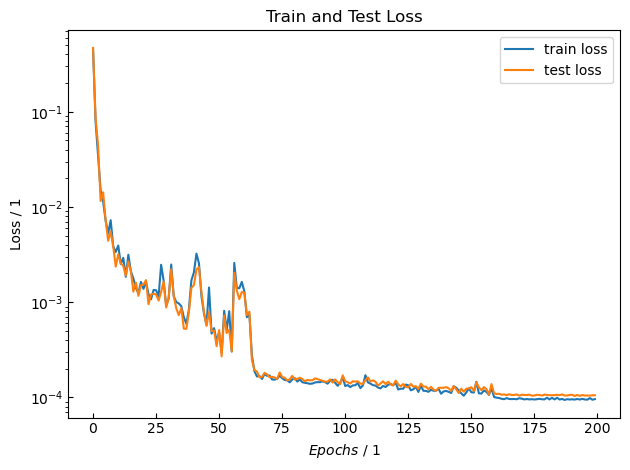

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999266439755087 , R^2(NH3) = 0.9998835746256208
Test Dataset: R^2(H2) = 0.9999027544513924 , R^2(NH3) = 0.9998794877071754
Max Error Training: |x_H2 - x_H2,pred| = 0.010278468323999035 , |x_NH3 - x_NH3,pred| = 0.005316583828007787
Max Error Test: |x_H2 - x_H2,pred| = 0.006577532408540532 , |x_NH3 - x_NH3,pred| = 0.005790141858187048


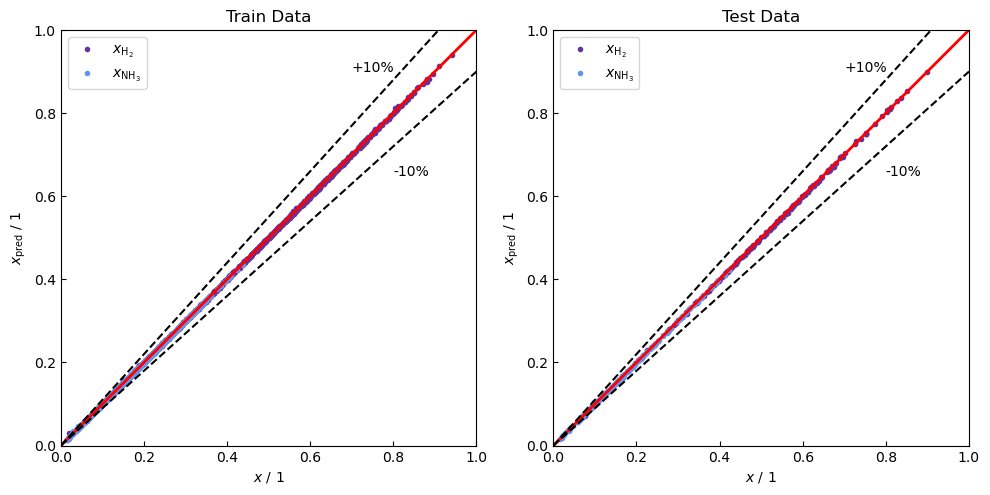

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

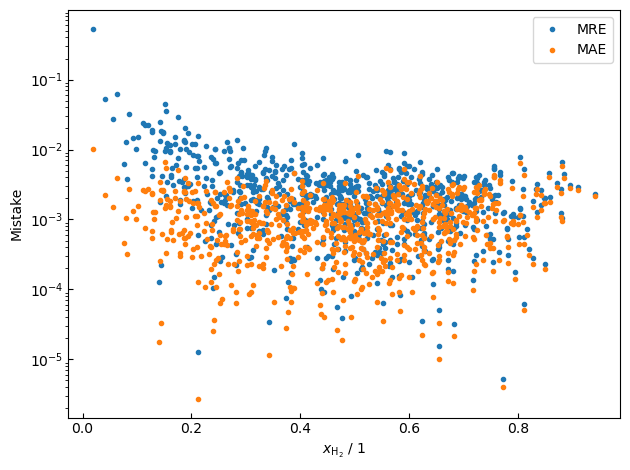

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

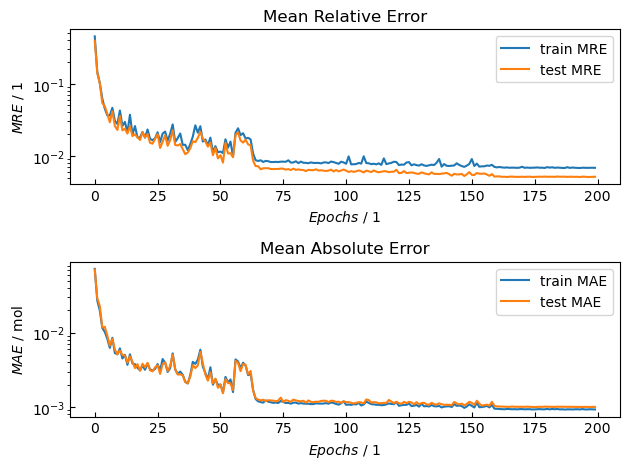

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

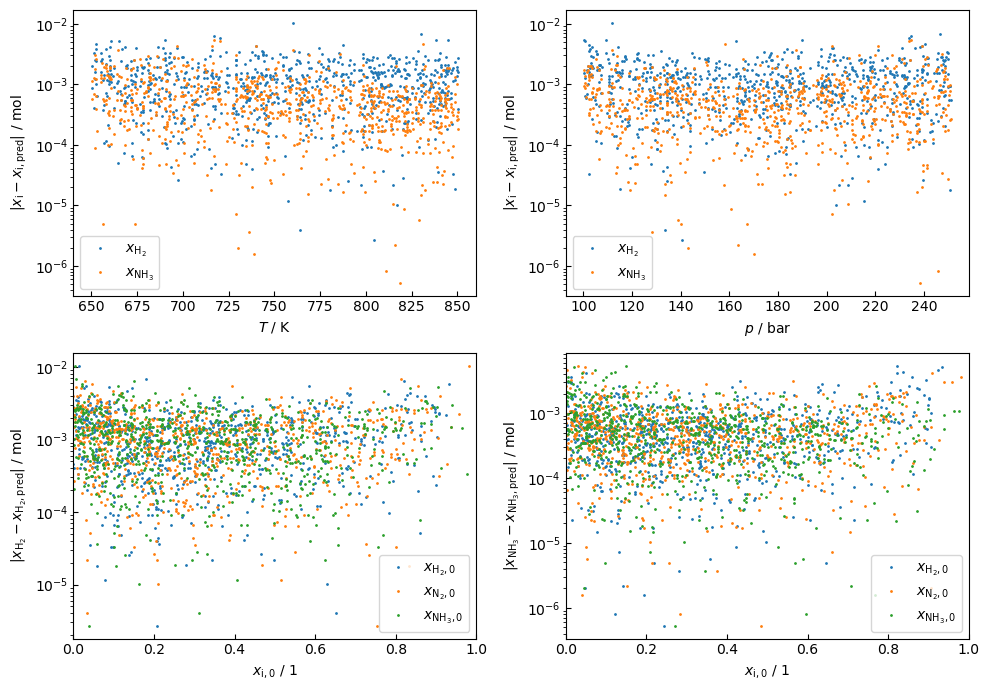

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

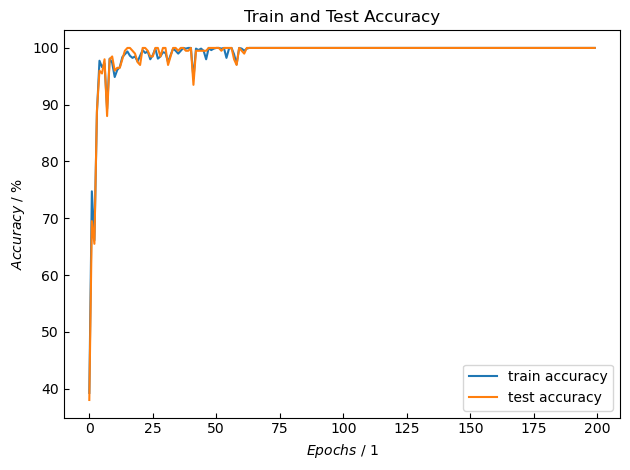

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.015625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.4926, -0.6412, -0.3385, -0.1537,  0.4893],
        [ 1.2257, -1.3317,  0.9983, -0.1846, -0.7910],
        [ 0.1093, -0.2494,  1.4727, -0.1235, -1.3191],
        [-1.1313, -0.8847, -0.6975,  1.6285, -0.9799],
        [ 0.0511,  0.2952,  2.1183, -1.1227, -0.9314],
        [-1.6303, -0.8962, -0.5810,  1.2246, -0.6814],
        [ 0.8303, -0.3198,  1.1492, -0.1960, -0.9274],
        [ 1.5672, -1.6738, -1.0385, -0.7622,  1.7982],
        [ 1.4271, -1.3029,  0.9939, -1.1879,  0.2387],
        [-0.2789, -0.1213, -0.6003, -1.2213,  1.8374],
        [-1.6305, -1.0068,  0.5909,  0.1969, -0.7811],
        [-0.6585,  1.2857,  1.2868, -0.2277, -1.0301],
        [-0.3442,  0.2931, -0.5032,  0.1984,  0.2910],
        [-1.3805,  0.1357, -0.8486, -0.8917,  1.7442],
        [-0.0097,  0.6561,  0.2458, -1.0059,  0.7869],
        [ 0.0939, -0.9943, -1.2815,  0.6239,  0.6200],
        [-0.2553,  1.5256,  0.9490,  0.1977, -1.1334],
        [-0.6080,  0.7185,  0.0349,  1.1513, -1.2110],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 3.2153e-01,  1.0578e-01,  4.5859e-01,  1.3377e-01,  4.1856e-01],
         [-2.6760e-02, -4.9595e-02,  4.8034e-01, -4.4152e-02, -1.6978e-01],
         [-2.5247e-01,  4.0915e-02,  9.2937e-05,  3.8869e-02,  2.2932e-01],
         [ 1.4687e-01, -2.7587e-01, -4.3661e-01,  1.1949e-01,  1.0167e-01],
         [ 1.2109e-01,  3.9713e-01, -1.7562e-01,  4.1968e-02,  1.9846e-01],
         [-4.6108e-01, -6.6668e-03, -2.3798e-02,  2.5000e-01, -2.9781e-01],
         [ 4.4113e-01,  4.6709e-02, -2.5563e-01,  7.8854e-02, -9.9106e-02],
         [ 3.4513e-01, -3.3944e-01,  2.1854e-01, -4.7242e-01, -1.2797e-01],
         [-2.8061e-01,  1.7740e-01,  2.2805e-01, -4.8993e-01, -1.0346e-01],
         [ 3.8507e-01, -2.6911e-01,  7.3317e-02,  2.1052e-01,  2.5050e-01],
         [-1.3137e-01,  2.2498e-01, -4.4896e-02,  5.4198e-01, -6.9983e-02],
         [-5.8988e-01,  3.0138e-01, -5.0624e-01,  1.0950e-01, -1.7178e-01],
         [ 3.3394e-01, -3.2814e-02,  1.4427e-01, -5.3474e-01, -1.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1908, 0.3194, 0.5826, 0.4189, 0.8278],
        [0.2884, 0.3656, 0.4079, 0.9342, 0.3642]])
tensor([[ 0.1888, -0.1904],
        [-0.2682, -0.4829]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.4045,  1.6978, -0.8808,  1.9873, -1.1668],
        [ 0.2353, -0.2784, -0.5924,  0.9041, -0.3426],
        [-1.3295, -1.4094,  1.4341, -1.0822, -0.3013],
        [-0.3941,  0.9132,  0.4261, -0.4673,  0.0594],
        [-1.2624, -1.4083, -1.4108,  2.5834, -1.2559],
        [ 0.8218, -0.5642, -1.2145,  0.7551,  0.4202],
        [-0.1934, -1.0697, -1.2763, -1.2917,  2.5728],
        [-0.3468,  0.0643,  0.0356,  0.7220, -0.7729],
        [-1.1636,  0.2135,  0.0440,  0.0388, -0.0829],
        [ 0.7454,  1.6291,  0.1427,  1.0845, -1.2484],
        [ 1.0330, -1.0847, -1.3381,  0.6343,  0.6649],
        [-0.1491,  0.1733, -0.6346,  0.9814, -0.3803],
        [-1.6945,  0.8822,  2.1440, -0.7777, -1.3092],
        [-0.1676, -1.1162, -1.0605,  1.2696, -0.2568],
        [-1.1053, -1.5090, -1.0574, -1.3562,  2.4239],
        [ 1.0532,  0.6493,  1.2758, -0.5191, -0.7215],
        [ 0.5799, -1.4594, -0.7850,  1.8802, -1.1512],
        [-1.3180, -1.2691, -0.9571,  0.9244, -0.0054],
        [ 

#### Histogramme Verteilung von $xi$ und $x{_i}$

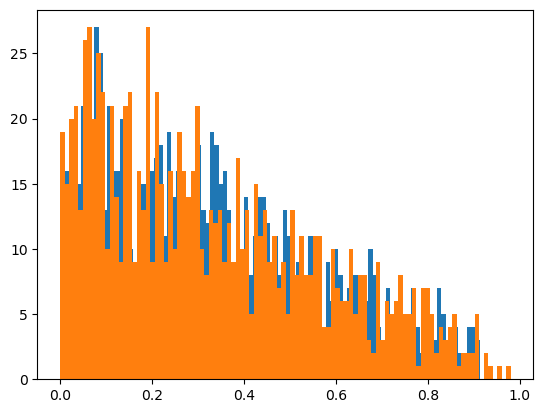

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_036.pth')
# np.savez('data/models/params_005_036.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)